In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# PLEASE INSTALL PRETTYTABLE IF YOU HAVE NOT IT ALREADY
from prettytable import PrettyTable

### Load the dataset weatherHistory.csv

In [168]:
original_data = pd.read_csv('weatherHistory.csv')


### Get rid of non-numerical columns of the dataset

In [169]:
only_numeric_df = original_data.select_dtypes(['number'])

### Use 'Temperature (C)' as your target variable. Plot the relationship of each of the numerical features with the target variable

/home/karen/anaconda3/envs/ml_beginner_course/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


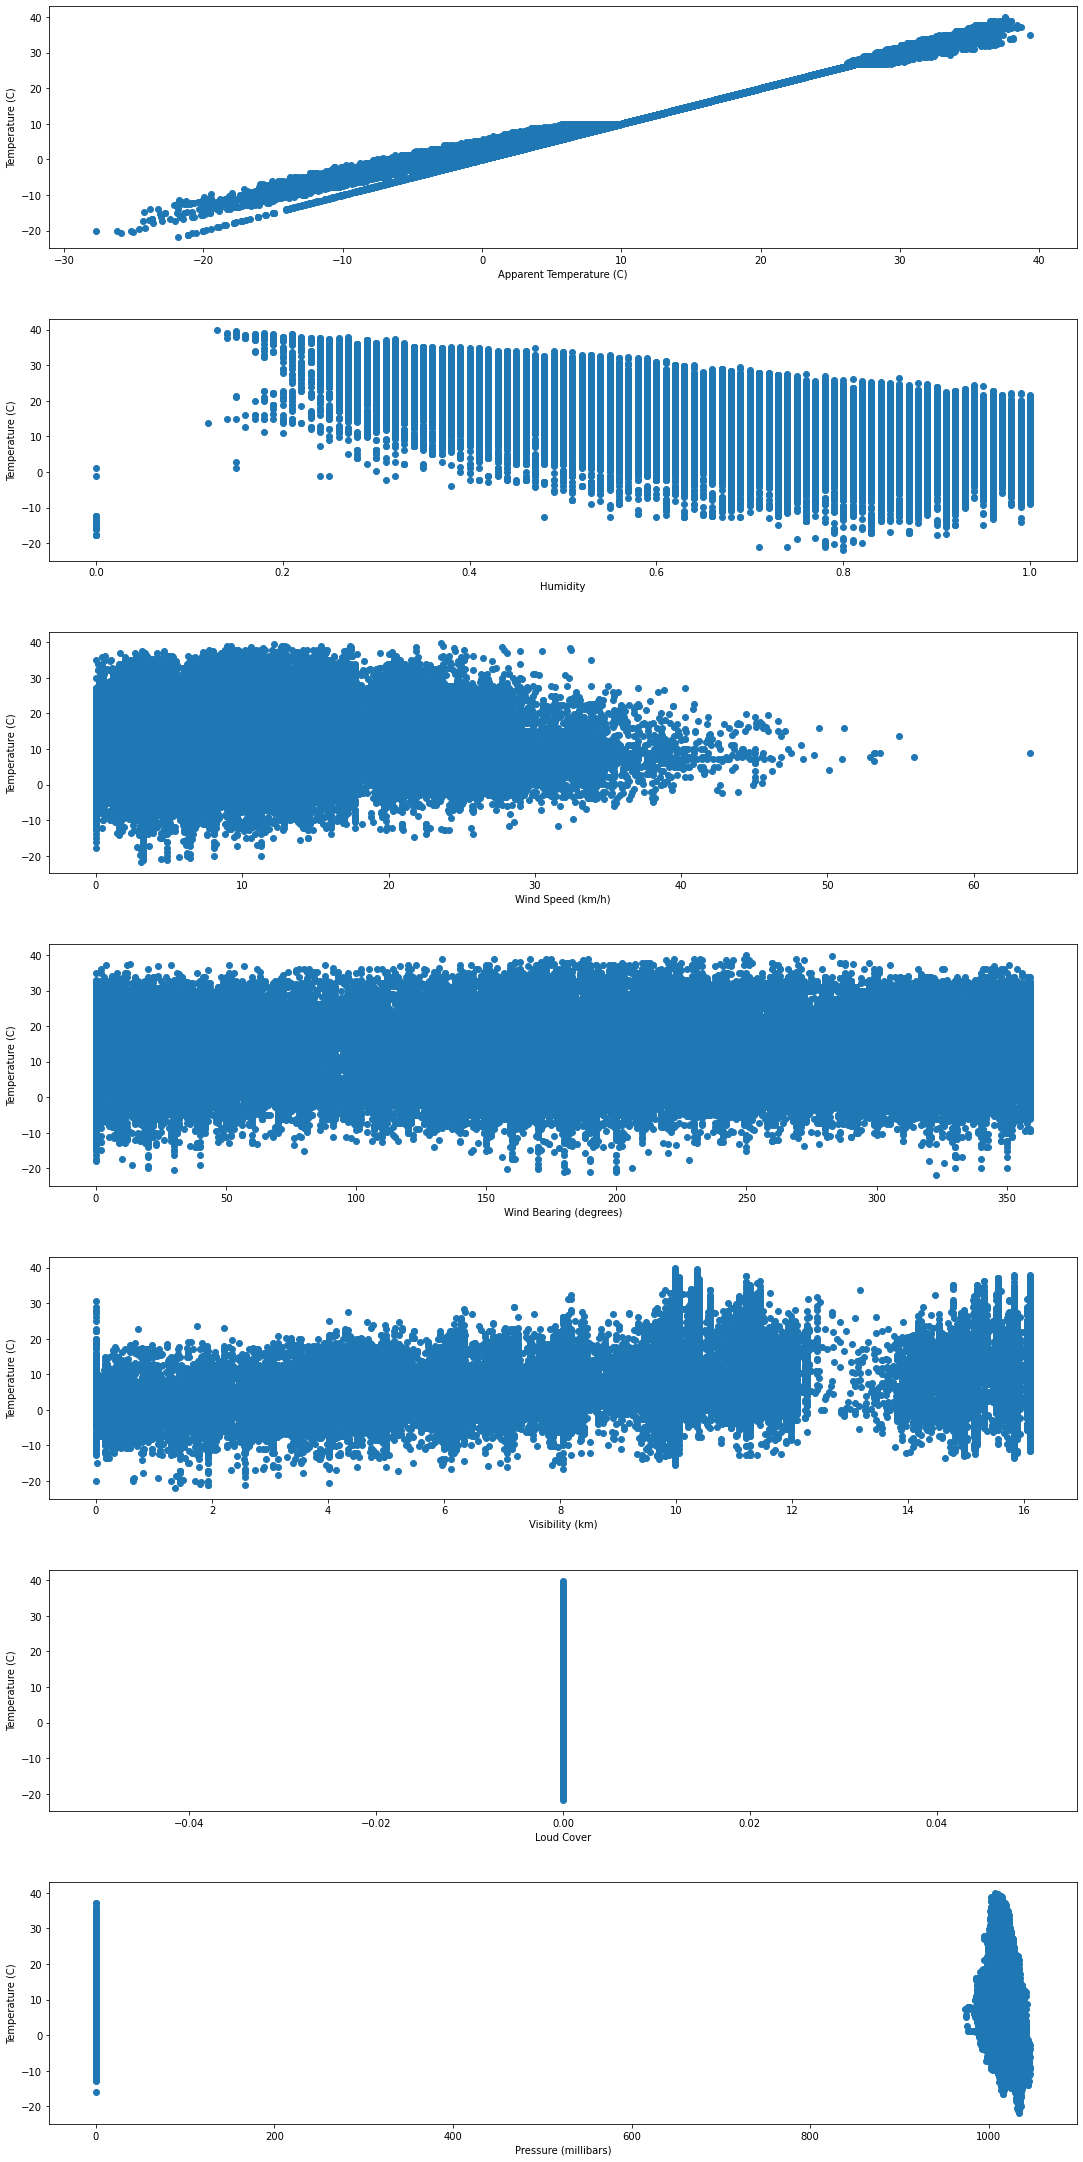

In [170]:
def plot_subplots(df, target_col):

    features = df.columns.drop(target_col)
    fig, axis = plt.subplots(len(features), 1)
    fig.set_figwidth(15)
    fig.set_figheight(30)
    fig.tight_layout(h_pad = 5)

    for i, feature in enumerate(features):
        axis[i].scatter(df[feature], df[target_col])
        axis[i].set_xlabel(feature)
        axis[i].set_ylabel(target_col)
    fig.show()
    
    
target_col = 'Temperature (C)'
plot_subplots(only_numeric_df, target_col)

### Leave only one feature that has a linear relationship with the target variable.

In [171]:
def get_best_feature(df, target_col):
    features = df.columns.drop(target_col)
    corr = {feature: df[[feature, target_col]].corr().iloc[1,0] for feature in features}
    return max(corr, key=lambda x: abs(corr.get(x)))


columns = only_numeric_df.columns.difference(['Apparent Temperature (C)'])
best_feature = get_best_feature(only_numeric_df[columns], target_col)
best_feature_df = only_numeric_df[[best_feature, target_col]]


### Divide the dataset into training and test sets with the ratio 80:20.

In [172]:
X_train, X_test, y_train, y_test = train_test_split(best_feature_df[best_feature], best_feature_df[target_col], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

### Implement a function fit_ridge_regression

In [173]:
def fit_ridge_regression(data_vector, response_vector, l=1):
    """
    :param data_vector: A pandas series object (i.e. a column of a dataframe),
                        where each element is a data point (x)
    :param response_vector: A pandas series object (i.e. a column of a dataframe),
                        where each element is label (y)
    :param l: ridge variable
    :return: numpy array beta of coefficients of the regression
    """
    #resetting indexes of input data
    data_vector.reset_index(drop=True, inplace=True)
    response_vector.reset_index(drop=True, inplace=True)
    
    #by general formula: beta = inverse_of(X_transp * X +l*I) * X_transp * Y
    
    #creating X matrix
    ones = pd.Series(np.ones(len(data_vector)))
    X = pd.concat([ones, data_vector], axis=1)
    
    #reseting column's index
    X.columns = range(X.shape[1])

    # transposed X
    X_tr = X.transpose()

    # X_tr * X
    tmp1 = X_tr.dot(X)
    tmp1.reset_index(drop=True, inplace=True)
    
    #multiplying identity matrix by l and adding to X_tr*X
    tmp1=tmp1.add( l * np.identity(len(tmp1)) )

    # inversing (X_tr * X)
    df_inv = pd.DataFrame(np.linalg.inv(tmp1.values))
    
    # finally output = inverse_of((X_transp * X)) * X_transp * Y
    result = df_inv.dot(X_tr).dot(response_vector)
    
    beta = result.values
    return beta

### Implement a function fit_polynomial_regression

In [174]:
def fit_polynomial_regression(data_vector, response_vector, degree=2):
    """
    :param data_vector: A pandas series object (i.e. a column of a dataframe),
                        where each element is a data point (x)
    :param response_vector: A pandas series object (i.e. a column of a dataframe),
                        where each element is label (y)
    :return: numpy array beta of coefficients of the regression
    """
    #resetting indexes of input data
    data_vector.reset_index(drop=True, inplace=True)
    response_vector.reset_index(drop=True, inplace=True)
    
    poly_features = PolynomialFeatures(degree=degree)
    
    #by general formula: beta = inverse_of(X_transp * X) * X_transp * Y
    
    #creating X matrix
    X = pd.DataFrame(poly_features.fit_transform(data_vector.values.reshape(-1, 1)))
    
    # transposed X
    X_tr = X.transpose()

    # X_tr * X
    tmp1 = X_tr.dot(X)

    # inversing (X_tr * X)
    df_inv = pd.DataFrame(np.linalg.inv(tmp1.values))
    
    # finally output = inverse_of((X_transp * X)) * X_transp * Y
    result = df_inv.dot(X_tr).dot(response_vector)
    
    beta = result.values
    return beta
fit_polynomial_regression(X_train, y_train, degree=5)

array([   -4.86314888,   317.29171371, -1107.91726006,  1653.45559621,
       -1194.73664047,   342.27916541])

### Tuning parameter lambda for ridge regression

In [175]:
def predict_ridge(beta, X):
    b0,b1 = beta
    return b0+b1*X

In [176]:
def find_best_lambda(func, X_train, y_train, X_val, y_val, degree = 5, depth = 3):
    def find_best_range(degree, range_ = None):
        #splitting passed range_ into new range with step = degree
        if range_:
             new_range = np.linspace(*range_, degree)   
        else:
            new_range = [10**d for d in range(degree)]
        
        #finding minimum rmse for ranges in new_range
        min_rmse = 10**10
        output_range = new_range[0], new_range[-1]
        for i in range(len(new_range)-1):
            a = new_range[i]
            b = new_range[i+1]
            l = np.mean((a,b))
            beta = func(X_train, y_train, l)
            y_pred = predict_ridge(beta, X_val)
            rmse = mean_squared_error(y_val, y_pred)
            if rmse < min_rmse:
                min_rmse = rmse
                output_range = a,b
        return output_range
        
    #finds best range in degrees ranges, i.e. for in (0,1) ,(1,10),(10,100)...,(10**degree-1, 10**degree)  (1)
    #then repeats step (1) for best found range in step (1)
    
    range_ = None
    for _ in range(depth):
        range_ = find_best_range(degree, range_)
    
    lambda_ = np.mean(range_)
    return lambda_

### Tuning parameter degree for polynomial regression

In [177]:
def predict_poly(beta, X):
    poly_features = PolynomialFeatures(len(beta)-1)
    X_arr = poly_features.fit_transform(X.values.reshape(-1, 1))

    return np.dot(X_arr,beta)

In [178]:
def find_best_poly_degree(func, X_train, y_train, X_val, y_val, max_degree=10):
    min_rmse = 10**10
    best_degree = 1
    
    for d in range(1, max_degree+1):
        beta = func(X_train, y_train, degree=d)
        y_pred = predict_poly(beta, X_val)
        rmse = mean_squared_error(y_val, y_pred)
        if rmse < min_rmse:
            min_rmse = rmse
            best_degree = d
            
    return best_degree

### Use the resulting train and test sets with the previous 2 functions to fit ridge regression and polynomial regression lines.

In [179]:
#tuning lambda parameter for ridge regression
best_l = find_best_lambda(func=fit_ridge_regression, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

#constructing classifier with best lambda
my_ridge_clf = fit_ridge_regression(X_train, y_train, l=best_l)
my_ridge_clf

array([ 34.43327564, -30.61962573])

In [180]:
#tuning degree parameter for polynomial regression
best_degree = find_best_poly_degree(func=fit_polynomial_regression, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

#constructing classifier with best degree
my_poly_clf = fit_polynomial_regression(X_train, y_train, degree=best_degree)
my_poly_clf

array([-1.33279420e+01,  9.42646868e+02, -7.96830116e+03,  3.51415728e+04,
       -9.18157740e+04,  1.46390873e+05, -1.39987551e+05,  7.37874735e+04,
       -1.64730241e+04])

### Calculate RMSE (root mean squared error) for ridge and polynomial regressions

In [181]:
y_pred_ridge = predict_ridge(my_ridge_clf, X_test)
y_pred_poly = predict_poly(my_poly_clf, X_test)

rmse_ridge = mean_squared_error(y_test,y_pred_ridge, squared=True)
rmse_poly = mean_squared_error(y_test,y_pred_poly, squared=True)
t = PrettyTable(['','My Ridge Regression', 'My Polynomial Regression'])
t.add_row(['RMSE', rmse_ridge, rmse_poly])

print(t)

+------+---------------------+--------------------------+
|      | My Ridge Regression | My Polynomial Regression |
+------+---------------------+--------------------------+
| RMSE |  53.99225019660352  |    53.12935771210276     |
+------+---------------------+--------------------------+


In [182]:
def fit_1d_linear_regression(data_vector, response_vector):
    """
    :param data_vector: A pandas series object (i.e. a column of a dataframe),
                        where each element is a data point (x)
    :param response_vector: A pandas series object (i.e. a column of a dataframe),
                        where each element is label (y)
    :return: numpy array beta of coefficients of the regression
    
    Note: You can avoid the intercept for simplicity 
    or include the intercept for an extra point
    """
    
    #resetting indexes of input data
    data_vector.reset_index(drop=True, inplace=True)
    response_vector.reset_index(drop=True, inplace=True)

    
    #by general formula: beta = inverse_of(X_transp * X) * X_transp * Y
    
    #creating X matrix
    ones = pd.Series(np.ones(len(X_train)))
    X = pd.concat([ones, data_vector], axis=1)
    
    #reseting column's index
    X.columns = range(X.shape[1])

    # transposed X
    X_tr = X.transpose()

    # X_tr * X
    tmp1 = X_tr.dot(X)
    tmp1.reset_index(drop=True, inplace=True)

    # inversing (X_tr * X)
    df_inv = pd.DataFrame(np.linalg.inv(tmp1.values))
    
    # finally output = inverse_of((X_transp * X)) * X_transp * Y
    result = df_inv.dot(X_tr).dot(response_vector)
    
    
    return result.values

### Now fit the ridge and polynomial regressions to your data using sklearn and compare the results with your own fit_1d_linear_regression function. Use RMSE for comparison.

In [183]:
my_1d_clf = fit_1d_linear_regression(X_train, y_train)
y_pred_1d = predict_ridge(my_1d_clf, X_test)
rmse_1d = mean_squared_error(y_test,y_pred_1d, squared=True)

In [184]:
from sklearn.linear_model import Ridge

sklearn_ridge_clf = Ridge(alpha=best_l)
sklearn_ridge_clf.fit(pd.DataFrame(X_train), y_train)
sk_ridge_y_pred = sklearn_ridge_clf.predict(pd.DataFrame(X_test))
sk_rmse_ridge = mean_squared_error(y_test,sk_ridge_y_pred, squared=True)

In [185]:
poly_features = PolynomialFeatures(degree=best_degree)
X_train_poly = poly_features.fit_transform(np.array(X_train).reshape(-1, 1))
sk_poly_clf = LinearRegression()
sk_poly_clf.fit(X_train_poly, y_train)
X_test_poly = poly_features.fit_transform(np.array(X_test).reshape(-1, 1))
sk_poly_y_pred = sk_poly_clf.predict(pd.DataFrame(X_test_poly))
sk_rmse_poly = mean_squared_error(y_test,sk_poly_y_pred, squared=True)

In [186]:
sk_rmse_ridge = mean_squared_error(y_test,y_pred_ridge, squared=True)
rmse_poly = mean_squared_error(y_test,y_pred_poly, squared=True)
t = PrettyTable(['Classifiers','RMSE'])
t.align["Classifiers"] = "l"

t.add_row(['My 1D classifier', rmse_1d])
t.add_row(['My ridge classifier', rmse_ridge])
t.add_row(['My polynomial classifier', rmse_poly])
t.add_row(['Sklearn ridge classifier', sk_rmse_ridge])
t.add_row(['Sklearn polynomial classifier', sk_rmse_poly])
print(t)

+-------------------------------+--------------------+
| Classifiers                   |        RMSE        |
+-------------------------------+--------------------+
| My 1D classifier              | 53.982754708375865 |
| My ridge classifier           | 53.99225019660352  |
| My polynomial classifier      | 53.12935771210276  |
| Sklearn ridge classifier      | 53.99225019660352  |
| Sklearn polynomial classifier | 53.12936938671649  |
+-------------------------------+--------------------+


### Use any additional visualizations that may help during your analysis.

In [187]:
colors = ['#FF00FF', '#808000', '#00FF00', '#008000', '#00FFFF', '#008080', '#0000FF', '#000080']

def draw_points(plt, x, y, x_label, y_label, legend, title=None):
    plt.figure(figsize=(20,8))    
    if title:
        plt.title(title)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.scatter(x, y, color='red', label = legend)
    plt.legend()

In [188]:
def draw_line(plt, x, y, color, legend, linewidth=2):
    plt.plot(x, y, color=color, linewidth=linewidth, label = legend)
    plt.legend()

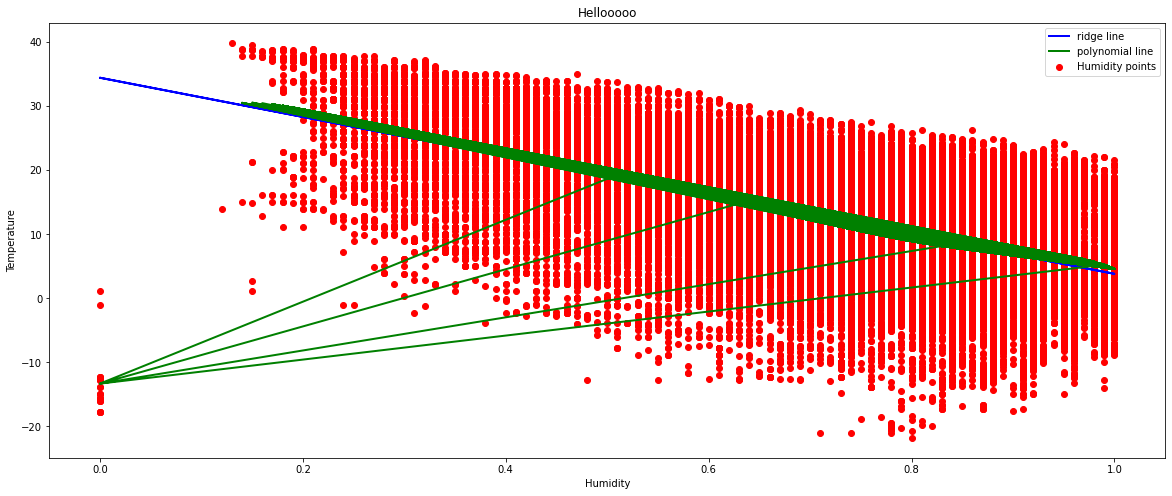

In [189]:
draw_points(plt, best_feature_df[best_feature], best_feature_df[target_col], x_label='Humidity', y_label='Temperature', legend='Humidity points', title='Hellooooo')
draw_line(plt, X_test, y_pred_ridge, color='blue', legend='ridge line')
draw_line(plt, X_test, y_pred_poly, color='green', legend='polynomial line')



<Figure size 1440x576 with 0 Axes>

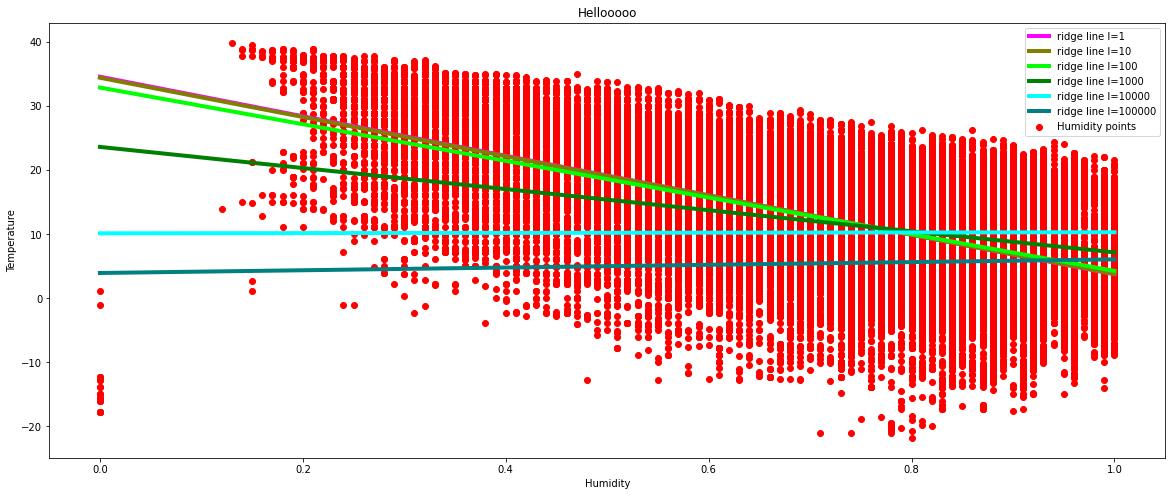

In [163]:
plt.figure(figsize=(20,8))
draw_points(plt, best_feature_df[best_feature], best_feature_df[target_col], x_label='Humidity', y_label='Temperature', legend='Humidity points', title='Hellooooo')
x = np.linspace(0,1,100)
for ind, l in enumerate([10**i for i in range(6)]):
    beta = fit_ridge_regression(X_train, y_train, l=l)
    y = predict_ridge(beta, x)
    draw_line(plt, x, y, color=colors[ind], linewidth=4, legend= f'ridge line l={l}')

In [197]:
rmse_train = []
rmse_test = []
degrees = range(1,15)
for degree in degrees:
    beta_train = fit_polynomial_regression(X_train, y_train, degree=degree)
    beta_test = fit_polynomial_regression(X_test, y_test, degree=degree)
    y_train_pred = predict_poly(beta_train, X_train)
    y_test_pred = predict_poly(beta_test, X_test)
    rmse_train.append(mean_squared_error(y_train, y_train_pred, squared=True))
    rmse_test.append(mean_squared_error(y_test, y_test_pred, squared=True))

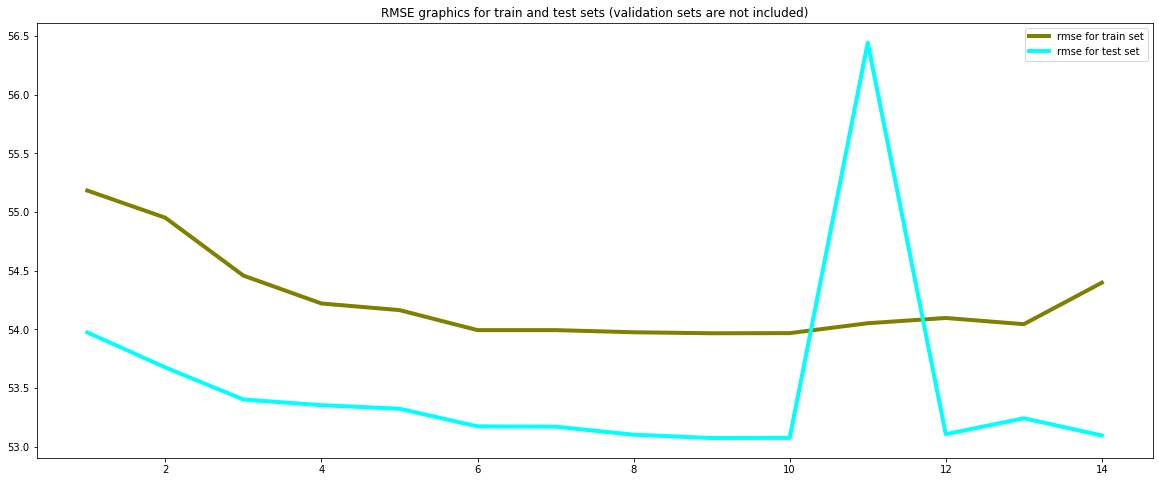

In [198]:
plt.figure(figsize=(20,8))
plt.title('RMSE graphics for train and test sets (validation sets are not included)')
draw_line(plt, x=degrees, y=rmse_train, color=colors[1], linewidth=4, legend= 'rmse for train set')
draw_line(plt, x=degrees, y=rmse_test, color=colors[4], linewidth=4, legend= 'rmse for test set')


### Conclusions

Received strange results for polynomial regression:
    1. Test set is fitted even better than train, and on degree=11 it has outlier
    2. Polynomial regression is not going to be overfitted even on high degrees (appr. 10). 
        Thus best degree turned out to be 9. I was sure that after visualization I'll see that it is overfitting 
        but no